Calculate Numerical Diffusivity
============================

This ipython notebook calculates the numerical diffusivity experienced by a tracer, associated to a specific configuration of the MITgcm. In particular, it was developed to calculate the equivalent diffusivity $\kappa$, defined (here) as $\kappa = \kappa_{pres}+\kappa_{num}$, where $\kappa_{pres}$ 
is the prescibed or explicit tracer diffusivity one imposes on the model and $k_{num}$ is the additional diffusivity due to numerical truncation errors. Note that there are two $\kappa_{pres}$ and therefore two $\kappa$, one for the horizontal dimensions and one for the vertical one.

These calculations try to reproduce the method used by [1] Abernathy et al. 2010, [2] Hill et al. 2011, and [3] Leibensperger and Plumb, 2013 to determine the numerical diffusivity MITgcm Southern Ocean configurations [1,2] and a baroclinic flow simulation simulation [3].

The method goes as follows:

From the evolution equation for the variance of the tracer concentration in the model output

\begin{equation}
\frac{1}{2}\frac{\partial{\overline{q^{2}}}}{\partial{t}}=-\kappa_{h} \overline{|\nabla_h q|^2}-\kappa_{v} \overline{(\frac{\partial{q}}{\partial {z}})^{2}}
\end{equation}

one can fit by a least squares regression, suitable values of $\kappa_h$ and $\kappa_v$ that satisfy the equation.

In [1]:
#KRM
import os

import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import nanmean

from math import *

%matplotlib inline

import numpy as np

import matplotlib.colors as mcolors

from netCDF4 import Dataset

import pylab as pl

from decimal import getcontext, Decimal, Inexact

In [2]:
#'''
#NAME
#    Custom Colormaps for Matplotlib
#PURPOSE
#    This program shows how to implement make_cmap which is a function that
#    generates a colorbar.  If you want to look at different color schemes,
#    check out https://kuler.adobe.com/create.
#PROGRAMMER(S)
#    Chris Slocum
#REVISION HISTORY
#    20130411 -- Initial version created
#    20140313 -- Small changes made and code posted online
#    20140320 -- Added the ability to set the position of each color
#'''

def make_cmap(colors, position=None, bit=False):
    #'''
    #make_cmap takes a list of tuples which contain RGB values. The RGB
    #values may either be in 8-bit [0 to 255] (in which bit must be set to
    #rue when called) or arithmetic [0 to 1] (default). make_cmap returns
    #a cmap with equally spaced colors.
    #Arrange your tuples so that the first color is the lowest value for the
    #colorbar and the last is the highest.
    #position contains values from 0 to 1 to dictate the location of each color.
    #'''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap

In [3]:
# Get field from MITgcm netCDF output
#
# statefile : string with /path/to/state.0000000000.t001.nc
# fieldname : string with the variable name as written on the netCDF file ('Temp', 'S','Eta', etc.)
#
def getField(statefile, fieldname):
    
    StateOut = Dataset(statefile)
    
    Fld = StateOut.variables[fieldname][:]
    
    shFld = np.shape(Fld)
    
    if len(shFld) == 1:
        
        return Fld
    
    if len(shFld) == 2:
        
        Fld2 = np.reshape(Fld,(shFld[0],shFld[1])) # reshape to pcolor order
        return Fld2 
    
    elif len(shFld) == 3:
        
        Fld2 = np.zeros((shFld[0],shFld[1],shFld[2])) 
        Fld2 = np.reshape(Fld,(shFld[0],shFld[1],shFld[2])) # reshape to pcolor order
        return Fld2 
        
    elif len(shFld) == 4:
        
        Fld2 = np.zeros((shFld[0],shFld[1],shFld[2],shFld[3])) 
        Fld2 = np.reshape(Fld,(shFld[0],shFld[1],shFld[2],shFld[3])) # reshape to pcolor order
        return Fld2
        
    else:
        
        print (' Check size of field ')
    
    


In [4]:

def dsum(iterable):
    
    "Full precision summation using Decimal objects for intermediate values"
    # Transform (exactly) a float to m * 2 ** e where m and e are integers.
    # Convert (mant, exp) to a Decimal and add to the cumulative sum.
    # If the precision is too small for exact conversion and addition,
    # then retry with a larger precision.
    from decimal import getcontext, Decimal, Inexact
    getcontext().traps[Inexact] = True

    total = Decimal(0)
    for x in iterable:
        mant, exp = frexp(x)
        mant, exp = int(mant * 2.0 ** 53), exp-53
        while True:
            try:
                total += mant * Decimal(2) ** exp
                break
            except Inexact:
                getcontext().prec += 1
    return float(total)


Important input parameters:
------------------------

In [5]:
#nx = 120  # number of x points in domain
#ny = 90  # number of y points in domain
#nz = 35   # number of z levels in domain
#nt = 10   # number of output files (n time) 

nx = 360  # number of x points in domain
ny = 360  # number of y points in domain
nz = 90   # number of z levels in domain
nt = 6   # number of output files (n time) 

Load output filenames:


In [6]:
### Load output filenames ###

#filename = '/ocean/kramosmu/MITgcm/CanyonUpwelling/180x180x35_BodyForcing_6Tr_LinProfiles/run11/output_0001/tave.0000000000.glob.nc'#'/ocean/kramosmu/MITgcm/CanyonUpwelling/120x90x35_UpwLinRampWind_1Tr_LinProfiles/run30/output_0001/state.0000000000.t001.nc'
filename = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_BodyForcing_6Tr_LinProfiles/run01/mnc_0001/tave.0000000000.glob.nc'
StateOut = Dataset(filename)
#for dimobj in StateOut.variables.values():
#    print dimobj

filename2 = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_BodyForcing_6Tr_LinProfiles/run01/mnc_0001/grid.t001.nc'#'/ocean/kramosmu/MITgcm/CanyonUpwelling/120x90x35_UpwLinRampWind_1Tr_LinProfiles/run30/output_0001/grid.t001.nc'
GridOut = Dataset(filename2)
#for dimobj in StateOut.variables.values():
#    print dimobj
filename3 = '/ocean/kramosmu/MITgcm/CanyonUpwelling/120x90x90_UpwLinRampWind_1Tr_LinProfiles/run01/mnc_0001/ptr_tave.0000000000.glob.nc'
PtracersOut = Dataset(filename3)
#for dimobj in PtracersOut.variables.values():
#    print dimobj


RuntimeError: No such file or directory

Make some plots 

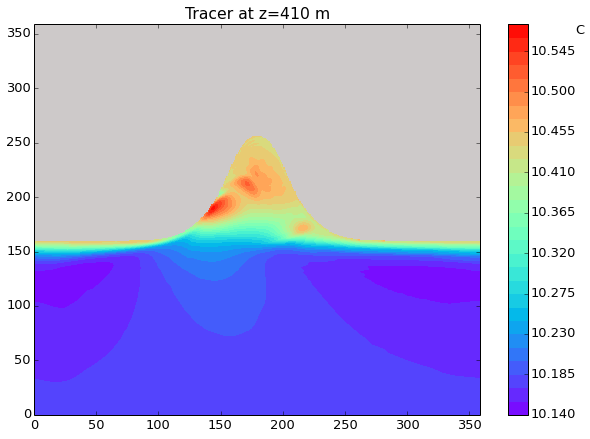

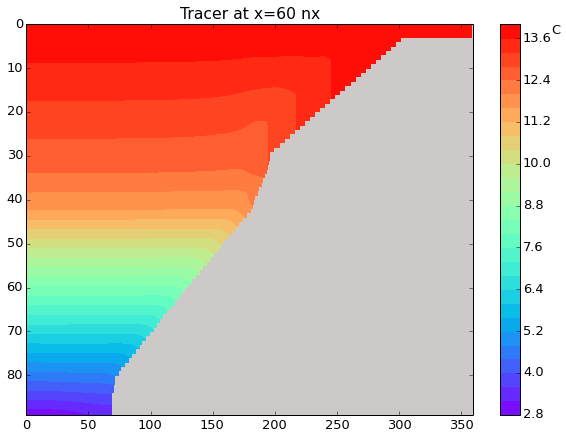

In [7]:
tracer1 = getField(filename,'Temp')

tracer1msk = np.ma.masked_values(tracer1, 0)

MASK = np.ma.getmask(tracer1msk)
   
    
### PLOT TRACER 1 at zlev and time###

zlev =50
time =4

plt.rcParams.update({'font.size':13})
plt.figure(figsize=(10,7))

ax=plt.gca()
ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

plt.contourf(tracer1msk[time,zlev,:,:],30, cmap='rainbow')
cb = plt.colorbar()
cb.set_label('C', position=(0, 1),rotation=0)

z=StateOut.variables['Z']

plt.title("Tracer at z=%d m" % -z[zlev])

 
plt.figure(figsize=(10,7))

ax=plt.gca()
ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

plt.contourf(tracer1msk[time,:,:,60],30, cmap='rainbow')
plt.gca().invert_yaxis()
cb = plt.colorbar()
cb.set_label('C', position=(0, 1),rotation=0)

z=StateOut.variables['Z']

plt.title("Tracer at x=60 nx")




Calculate the volume of the domain
-------------------------------
The volume of a tracer cell (remember we have an Arakawa C grid, so this changes depending on which kind of cell we are thinking about) is given by

$V(i,j,k)=depth \times area = (hfacC(i,j,k)\times dRf(k)) \times rA(i,j) = (hfacC(i,j,k)\times dRf(k)) \times dXg(i,j) \times dYg(i,j)$,

where hfacC is the fraction of the cell that is open (not occupied with land). So, the total volume of the domain is 

$\sum\limits_{i=1}^{nx}{\sum\limits_{j=1}^{ny}{\sum\limits_{k=1}^{nz}{(hfacC(i,j,k)\times dRf(k)) \times rA(i,j)}}}$

In [8]:
DomVolume = 0.0

hFacC = getField(filename2,'HFacC')
drF   = getField(filename2,'drF')
rAC   = getField(filename2,'rA')


for ii in np.arange(nx):
    
    for jj in np.arange(ny):
        
        for kk in np.arange(nz):
            
            DomVolume = DomVolume + hFacC[kk,jj,ii]*drF[kk]*rAC[jj,ii]
                
print('\n The total volume is %e m^3 \n' %DomVolume)



 The total volume is 6.102853e+12 m^3 



1st Term: The volume-weighted average of the squared concentration
-------------------------------------------------------------
The first term in the variance evolution equation is $\frac{1}{2}\frac{\partial{\overline{q^{2}}}}{\partial{t}}$. Note that we care about the time derivative of the variance, so that the mean concentration that usually appears in the definition of variance will not play a role here, since it is constant in time (we are not putting in or letting out any tracer). 

We are going to calculate $\overline{q^2}$, the volume-weighted average of the squared concentration, and then the time derivative of that using a centered difference scheme.

In [9]:
### Calculate the volume-weighted mean of q^2

q2mean = np.zeros((nt,1))

for tt in np.arange(nt):
    q2sum = 0.0
    for kk in np.arange(nz):
        
        for jj in np.arange(ny):
            
            q2sum = q2sum + np.sum(((hFacC[kk,jj,:]*drF[kk]*rAC[jj,:])/DomVolume)*(tracer1[tt,kk,jj,:])**2)
                
    q2mean[tt] = q2sum
   
    print('volume-weighted mean of q^2 nt=%d is %e  \n' %(tt, q2mean[tt]))



volume-weighted mean of q^2 nt=0 is 9.685017e+01  

volume-weighted mean of q^2 nt=1 is 9.685998e+01  

volume-weighted mean of q^2 nt=2 is 9.689125e+01  

volume-weighted mean of q^2 nt=3 is 9.693985e+01  

volume-weighted mean of q^2 nt=4 is 9.699614e+01  

volume-weighted mean of q^2 nt=5 is 9.705057e+01  

volume-weighted mean of q^2 nt=6 is 9.710773e+01  



In [10]:
### Calculate time derivative 
dt = (3600.*12.) # half day

dqdt = np.zeros(nt-2)

for tt in np.arange(nt-2):
    
    dqdt[tt] = (q2mean[tt+2]-q2mean[tt])/(2.*dt) # approximation of time derivative of v-w mean q^2
      

2nd Term: The volume-weighted average of the squared horizontal gradient
------------------------------------------------------------------
The second term in the variance evolution equation is $-\kappa_{h} \overline{|\nabla_h q|^2}$. Next, we calculate the square of the horizontal gradient $|\nabla_h q|^2=(\frac{\partial{q}}{\partial{x}})^2+(\frac{\partial{q}}{\partial{y}})^2$.

Spatial derivatives are approximated using a centered-difference scheme.

In [11]:

### Calculate mean of (dq/dx)^2 + (dq/dy)^2)

dxG = getField(filename2,'dxG')
dyG = getField(filename2,'dyG')

qmeanDh = np.zeros((nt,1))
qmeanDx = np.zeros((nt,1))
qmeanDy = np.zeros((nt,1))

for tt in np.arange(nt):
    
    sumDx = 0.0
    
    tracer2dx = tracer1[tt,:,:,2:nx]
    tracer0dx = tracer1[tt,:,:,0:nx-2]
    tracerDerX = ((tracer2dx-tracer0dx)/(2.0*dxG[1:,1:nx-1]))**2
    
    
    for kk in np.arange(nz):
        for jj in np.arange(ny):
            sumDx = sumDx + np.sum((hFacC[kk,jj,1:nx-1]*drF[kk]*rAC[jj,1:nx-1])*(tracerDerX[kk,jj,:]))
          
        #print(sumDx)    
    
    qmeanDx[tt] = sumDx/DomVolume
    
    print('The v-w mean of (dq/dx)^2 at nt=%d is %e \n' % (tt,qmeanDx[tt]))            
   
    
for tt in np.arange(nt):
    
    sumDy = 0.0
    
    tracer2dy = tracer1[tt,:,2:ny,:]
    tracer0dy = tracer1[tt,:,0:ny-2,:]
    tracerDerY = ((tracer2dy-tracer0dy)/(2.0*dyG[1:ny-1,1:]))**2
    
    
    for kk in np.arange(nz):
        for ii in np.arange(nx):
            sumDy = sumDy + np.sum((hFacC[kk,1:ny-1,ii]*drF[kk]*rAC[1:ny-1,ii])*(tracerDerY[kk,:,ii]))
            
    qmeanDy[tt] = sumDy/DomVolume 
    
    print('The v-w mean of (dq/dy)^2 at nt=%d is %e \n' % (tt,qmeanDy[tt]))            

                
qmeanDh = qmeanDx + qmeanDy


The v-w mean of (dq/dx)^2 at nt=0 is 2.948817e-07 

The v-w mean of (dq/dx)^2 at nt=1 is 2.989325e-07 

The v-w mean of (dq/dx)^2 at nt=2 is 3.073961e-07 

The v-w mean of (dq/dx)^2 at nt=3 is 3.120020e-07 

The v-w mean of (dq/dx)^2 at nt=4 is 3.130821e-07 

The v-w mean of (dq/dx)^2 at nt=5 is 3.138460e-07 

The v-w mean of (dq/dx)^2 at nt=6 is 3.146316e-07 

The v-w mean of (dq/dy)^2 at nt=0 is 6.937249e-07 

The v-w mean of (dq/dy)^2 at nt=1 is 6.990309e-07 

The v-w mean of (dq/dy)^2 at nt=2 is 7.153746e-07 

The v-w mean of (dq/dy)^2 at nt=3 is 7.269161e-07 

The v-w mean of (dq/dy)^2 at nt=4 is 7.300211e-07 

The v-w mean of (dq/dy)^2 at nt=5 is 7.322806e-07 

The v-w mean of (dq/dy)^2 at nt=6 is 7.344811e-07 



3rd Term: The volume-weighted average of the squared vertical derivative
------------------------------------------------------------------
The third term in the variance evolution equation is $-\kappa_{v} \overline{(\frac{\partial{q}}{\partial{z}})^2}$. Next, we calculate the square of the vertical gradient $(\frac{\partial{q}}{\partial{z}})^2$.

The vertical derivative is approximated using a centered-difference scheme.

In [12]:
### Calculate mean of (dq/dz)^2 

qmeanDz = np.zeros((nt,1))


for tt in np.arange(nt):
    qsumDz = 0.0
    for ii in np.arange(nx):
        
        for jj in np.arange(ny):
            
            for kk in np.arange(nz-2):
                
                if (hFacC[kk,jj,ii]*drF[kk])+(hFacC[kk+1,jj,ii]*drF[kk+1]) == 0:
                    
                    continue
                    
                else :
                    
                   qsumDz =qsumDz +(hFacC[kk,jj,ii]*drF[kk]*rAC[jj,ii])*(((tracer1[tt,kk+2,jj,ii]-tracer1[tt,kk,jj,ii])/((hFacC[kk+1,jj,ii]*drF[kk+1])+(hFacC[kk,jj,ii]*drF[kk])))**2)
                   
    qmeanDz[tt] = qsumDz/DomVolume
    
    print('Mean (dq/dz)^2 at nt=%d is %e \n' %(tt, qmeanDz[tt]))
  

    
    


Mean (dq/dz)^2 at nt=0 is 6.903947e-02 

Mean (dq/dz)^2 at nt=1 is 6.922494e-02 

Mean (dq/dz)^2 at nt=2 is 7.006685e-02 

Mean (dq/dz)^2 at nt=3 is 7.109276e-02 

Mean (dq/dz)^2 at nt=4 is 7.152889e-02 

Mean (dq/dz)^2 at nt=5 is 7.167907e-02 

Mean (dq/dz)^2 at nt=6 is 7.176091e-02 



Tracer variance plots:
--------------------

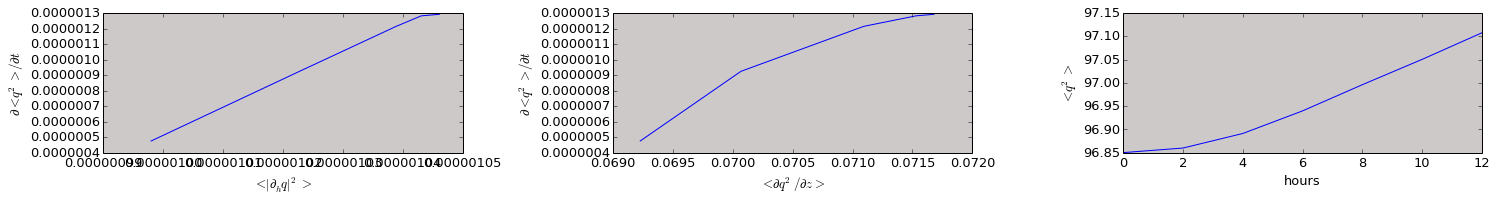

In [13]:

fig1=plt.figure(figsize=(21,3))

plt.subplot(1,3,1)
ax=plt.gca()
ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

plt.plot(qmeanDh[1:len(qmeanDh)-1],dqdt)


plt.xlabel('$<|\partial_{h}q|^2>$')

plt.ylabel('$\partial{<q^2>}/\partial{t}$')
    

plt.subplot(1,3,2)
ax=plt.gca()
ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

plt.plot(qmeanDz[1:len(qmeanDz)-1],dqdt)


plt.xlabel('$<\partial{q^2}/\partial{z}>$')

plt.ylabel('$\partial{<q^2>}/\partial{t}$')

plt.subplot(1,3,3)
ax=plt.gca()
ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

plt.plot(np.arange(0,nt*2,2.0),q2mean)

plt.xlabel('hours')

plt.ylabel('$<q^2>$')

plt.tight_layout()

Linear regression for $\kappa_h$ and $\kappa_v$
------------------------------------------

In the regression results box, x1 corresponds to $\kappa_h$ and x2 to $\kappa_v$.

In [14]:
import pandas as pd
import statsmodels.api as sm

dt = 1*3600.0*24.0 # 2hrs

x = np.column_stack((qmeanDh[1:len(qmeanDh)-1], qmeanDz[1:len(qmeanDz)-1])) #variance of space derivatives

y = 0.5*dqdt[0:len(dqdt)]

print(np.shape(x))
print(np.shape(y))

## fit a OLS model with intercept 
#x = sm.add_constant(x)
#est = sm.OLS(y, x).fit()
est = sm.GLS(y,x).fit()
est.summary()


(5, 2)
(5,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.984
Model:                            GLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     94.17
Date:                Fri, 28 Nov 2014   Prob (F-statistic):            0.00196
Time:                        10:19:27   Log-Likelihood:                 75.438
No. Observations:                   5   AIC:                            -146.9
Df Residuals:                       3   BIC:                            -147.7
Df Model:                           2                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            26.0902      7.708      3.385      0.043         1.561    50.619
x2            -0.0004      0.000     -3.319      0.045        -0.001 -1.54e-05
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.348
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.445
Skew:                          -0.603   Prob(JB):                        0.801
Kurtosis:                       2.176   Cond. No.                     1.39e+07
==============================================================================

Warnings:
[1] The smallest eigenvalue is 1.29e-16. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [15]:

dt = 1*3600.0*24.0 # 2hrs

#x = np.column_stack((qmeanDh[1:len(qmeanDh)-1], qmeanDz[1:len(qmeanDz)-1])) #variance of space derivatives

y = 0.5*dqdt[0:len(dqdt)]

x1=qmeanDh[1:len(qmeanDh)-1]
x2=qmeanDz[1:len(qmeanDz)-1]
## fit a OLS model with intercept 
#x = sm.add_constant(x)
#est = sm.OLS(y, x).fit()
est = sm.GLS(y,x1).fit()
est.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.927
Model:                            GLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     50.60
Date:                Fri, 28 Nov 2014   Prob (F-statistic):            0.00206
Time:                        10:19:37   Log-Likelihood:                 71.584
No. Observations:                   5   AIC:                            -141.2
Df Residuals:                       4   BIC:                            -141.6
Df Model:                           1                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.5062      0.071      7.113      0.002         0.309     0.704
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.601
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.846
Skew:                          -0.949   Prob(JB):                        0.655
Kurtosis:                       2.322   Cond. No.                         1.00
==============================================================================

Warnings:
[1] The smallest eigenvalue is 5.3e-12. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [16]:
dt = 1*3600.0*24.0 # 2hrs

x = np.column_stack((qmeanDh[1:len(qmeanDh)-1], qmeanDz[1:len(qmeanDz)-1])) #variance of space derivatives

y = 0.5*dqdt[0:len(dqdt)]

x1=qmeanDh[1:len(qmeanDh)-1]
x2=qmeanDz[1:len(qmeanDz)-1]
## fit a OLS model with intercept 
#x = sm.add_constant(x)
#est = sm.OLS(y, x).fit()
est = sm.GLS(y,x2).fit()
est.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.924
Model:                            GLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     48.94
Date:                Fri, 28 Nov 2014   Prob (F-statistic):            0.00220
Time:                        10:19:48   Log-Likelihood:                 71.507
No. Observations:                   5   AIC:                            -141.0
Df Residuals:                       4   BIC:                            -141.4
Df Model:                           1                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1          7.362e-06   1.05e-06      6.996      0.002      4.44e-06  1.03e-05
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.609
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.863
Skew:                          -0.964   Prob(JB):                        0.650
Kurtosis:                       2.348   Cond. No.                         1.00
==============================================================================
"""